## Series of routines for generating polymorphic crystalline surfaces. 

Not robust, but can be with some minor tweaks

In [560]:
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

Routines to see if point is within polygon

In [561]:
# returns indices of points within polygon
def pnpoly(
    vert, # list of vertices defining closed polygon
    test  # pts considered
):
    n = vert.shape[0]
    m = test.shape[0]
    
    result = np.zeros(m)
    
    for i in range(n):
        j = (i+n-1) % n
        for k in range(m):
            if (((vert[i,1] > test[k,1])!=(vert[j,1] > test[k,1])) and\
               (test[k,0] < (vert[j,0]-vert[i,0])*(test[k,1]-vert[i,1])/ \
               (vert[j,1]-vert[i,1]) + vert[i,0])):
               result [k] = not result [k]
    return result         

# returns list of points within polgon
def GetWithinPoly(vert,test):
    result =pnpoly(vert,test)
    passing = test[np.argwhere(result>0),:]
    nPts = np.shape(passing)[0]
    passing = np.reshape(passing,[nPts,2])
    return passing

#### Test algorithm

In [564]:
# bounding vertices
verts = np.array([[0,0],[1,0],[1,1],[0,1]])

# random pts
pts = np.reshape(np.random.rand(1000*2), [1000,2])-np.array([0.5,0.5])
pts *= 4.

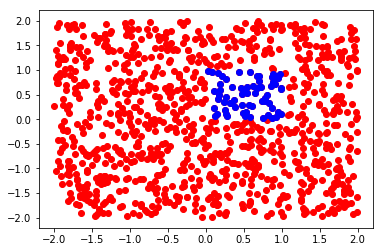

In [565]:
# find those within polygon
passing = GetWithinPoly(verts,pts)

plt.scatter(pts[:,0],pts[:,1],color='r')
plt.scatter(passing[:,0],passing[:,1],color='b')

Generate random polygon regions (centered at 0,0)

- probably want to revise this so that the vectors are randomly distributed within 2pi/n sectors; this would prevent angles >pi, which will screw up polygon generation later
- need to enforce that angles are < pi rad
- probably want to base vector lengths on their intersection with a square bounding box (actually, not necessary if I only select from points generated within a square region (see below))

In [566]:
# choose randomly on grid 
def GenIntersecting(nCuts=4,length=10.):
    eps = 1e-1
    daRange =[0,2*np.pi-eps]

    # randomize over 2pi
    thetas = np.sort(np.random.rand(nCuts))
    thetas = thetas*daRange[1]-thetas*daRange[0]
    #print thetas
    coords = np.array([np.cos(thetas),np.sin(thetas)])
    coords = np.transpose(coords)
    coords *= length
    #print np.sin(thetas)

    # make into vectors 
    vecs = []
    plt.axis('equal')
    for i,v in enumerate(coords):
        #print v
        z = np.array([[0,0],v])
        vecs.append(z)
    #    plt.plot()  
        plt.plot(z[:,0],z[:,1])       
    #plt.xlim([-1,1])
    #plt.ylim([-1,1])
    return vecs

For now, run a few times until angles are all < pi rad and aren't overly small

(4, 2, 2)


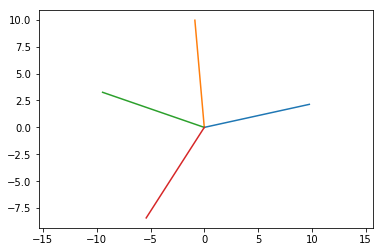

In [549]:
vecs = GenIntersecting(nCuts=4)
print np.shape(vecs)

In [567]:
# 
# vectors from previous iter were ordered by angle; here, we create 
# isolated regions by defining a vector that links the termini of two 'consecutive' 
# vectors
def GenClosedPolygons(
    vecs, # list of 'ordered' vectors from GenIntersecting
    displacement = 0  # displace each polygon a distance of 'displacement' from origin (in direction of bisecting vectors)
):
    polygons = []

    vecs=np.asarray(vecs)
    n = np.shape(vecs)[0]
    #ar = np.arange(ve)
    for i in np.arange(n):
        s=i
        if i<n-1:
            f = i+1
        else:  # grab next index
            f = 0  
        #print s,f
        vertA = vecs[s,1,:] # '0' is origin
        vertB = vecs[f,1,:]

        polygoni = np.array([
            [0,0],vertA,vertB,[0,0]
        ])
        
        # displace 
        dispVec = 0.5*(vertA + vertB)
        #dispVec = np.array([0,1.])
        dispVec *= displacement
        #print polygoni
        #print polygoni + dispVec
        #print "###"
        polygoni = polygoni + dispVec
        
        polygons.append(polygoni)
    return polygons

In [569]:
polygons  = GenClosedPolygons( vecs,displacement=0.04 )

#### Just a demo to show how points are distributed within polygons

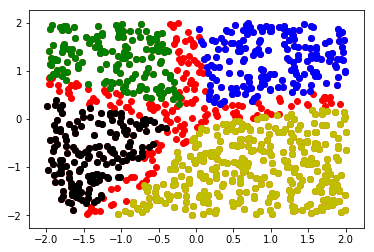

In [570]:
# safe for up to 4 regions
colors = ['b','g','k','y']


plt.scatter(pts[:,0],pts[:,1],color='r')
for i in np.arange( len(polygons)) :
    region = polygons[i]

    # displaying points within each respective region
    passing = GetWithinPoly(region,pts) 
    plt.scatter(passing[:,0],passing[:,1],color=colors[i%4]) # repeat every 4 
   

#### Find randomly distributed (amorphous) region between polygons
Technically should use an MC engine to pack finite-sized points, but not a big deal

In [571]:
def FindInterfacialPoints(pts,polygons):
    results = np.zeros( np.shape(pts)[0] )
    for i in np.arange( len(polygons)) :
        region = polygons[i]

        # grabbing indices, so we can later select points that are -not- within the polygons
        # for 'interfaces'
        resultsi = pnpoly(region,pts)
        results+=resultsi

    idx = np.argwhere( results == 0)
    interfacial =  pts[idx,:]
    nPts= np.shape(idx)[0]
    interfacial = np.reshape( interfacial, [nPts,2])
    #print np.shape( interfacial )
    plt.scatter( interfacial[:,0],interfacial[:,1]  )
    
    return interfacial

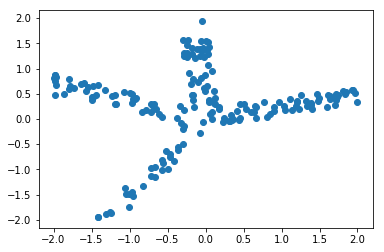

In [572]:
# random pts (in [-2,-2]..[2,2])
boundingBox = np.array([[-1,-1],[1,1]]) # WILL ASSUMED SQUARE FOR NOW
boundingBox *= 2
nPts =  1000 
pts = np.reshape(np.random.rand(nPts*2), [nPts,2])-np.array([0.5,0.5])
pts *= boundingBox[1,0]-boundingBox[0,0]

interfacialPts = FindInterfacialPoints(pts,polygons)

#### Simulating 'polymorphism'
For simplicity, I'm using a lattice comprised of a square unit cell. This can easily be replaced with the hexagonal code I wrote in my other notebook. 

In [574]:
# regularly-spaced points
s = np.sqrt(2) # so we will always fill bounding box, despite rotation
x,y = np.meshgrid(
    np.linspace(boundingBox[0,0]*s,boundingBox[1,0]*s,31),
    np.linspace(boundingBox[0,0]*s,boundingBox[1,0]*s,31),
)
xf = np.ndarray.flatten(x)
yf = np.ndarray.flatten(y)

lattice = np.array(zip(xf,yf))
#print coords

Randomize rotations

In [575]:
#t = 3*np.pi/2.
def rot(t):
    R = np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
    return R
#print R

test

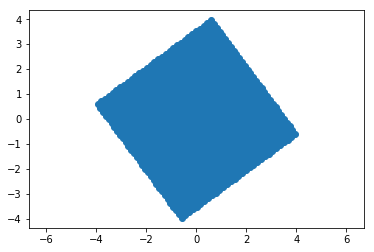

In [576]:
def randrot(coords):
    t = (np.random.rand(1) * np.pi/4.)[0]
    R = rot( t )
    c = np.dot(R,np.transpose(lattice))
    c = np.transpose(c)
    return c

c = randrot(coords)
plt.axis('equal')
plt.scatter(c[:,0],c[:,1])

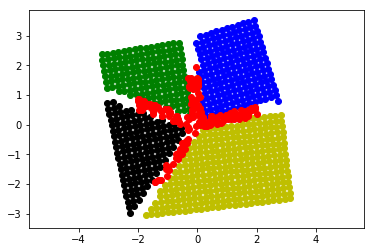

In [577]:
plt.axis('equal')
allPassing = []
for i in np.arange( len(polygons)) :
    region = polygons[i]
    
    # create random xtal config 
    c = randrot(lattice)

    # displaying points within each respective region
    passing = GetWithinPoly(region,c) 
    plt.scatter(passing[:,0],passing[:,1],color=colors[i%4]) # repeat every 4 
    allPassing.append(passing)

# add interface     
plt.scatter( interfacialPts[:,0],interfacialPts[:,1],color='r'  )   
allPassing.append(interfacialPts)

allPassing = np.concatenate(allPassing)


Finally, grab only those points within bounding box 

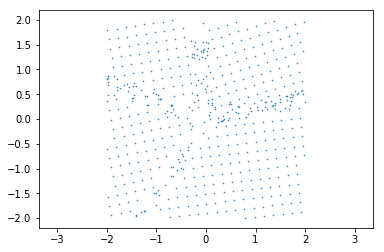

In [578]:
bounds = np.array([
  boundingBox[0,:],
  [boundingBox[0,0],boundingBox[1,1]],
  boundingBox[1,:],    
  [boundingBox[1,0],boundingBox[0,1]],   
  boundingBox[0,:]    
])
#print bounds

plt.axis('equal')
passing = GetWithinPoly(bounds,allPassing) 
plt.scatter(passing[:,0],passing[:,1],s=0.3)


In [579]:
pwd


u'/Users/huskeypm'